# Greenhouse Gas Emissions Prediction Project Summary

## Project Overview
This project develops machine learning models to predict greenhouse gas emissions across various supply chain sectors using the SupplyChainEmission.csv dataset. The goal is to identify emission patterns and create a predictive tool for environmental impact assessment.

## Methodology
- **Data Processing**: Cleaned dataset by handling non-numeric values and missing data in emission factors
- **Feature Engineering**: Used numeric features including emission factors without margins and data quality metrics, with one-hot encoding for categorical variables
- **Model Development**: Trained and evaluated three regression models:
  - Linear Regression
  - Decision Tree
  - Random Forest (with GridSearchCV hyperparameter tuning)
- **Evaluation**: Measured performance using RMSE, MAE, and R² score on test data

## Key Results
- Random Forest models generally outperformed simpler models, demonstrating the non-linear relationships in emission data
- Hyperparameter tuning improved Random Forest performance significantly
- Feature importance analysis identified key factors driving emission predictions
- The best model was saved as a reusable .pkl file for future prediction tasks

This work provides organizations with a data-driven approach to estimate supply chain emissions and identify high-impact areas for sustainability initiatives.

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [19]:
# ======================
# 1. DATA LOADING & CLEANING
# ======================

# Load the CSV file
df = pd.read_csv('SupplyChainEmission.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Data Cleaning
# Remove rows where 'Supply Chain Emission Factors with Margins' is not numeric
df = df[df["Supply Chain Emission Factors with Margins"].apply(pd.to_numeric, errors='coerce').notnull()]

# Convert 'Supply Chain Emission Factors with Margins' to float
df["Supply Chain Emission Factors with Margins"] = df["Supply Chain Emission Factors with Margins"].astype(float)

# Drop duplicates
df = df.drop_duplicates()

# Check for non-numeric values in numeric columns
numeric_cols = [
    'Supply Chain Emission Factors without Margins',
    'Margins of Supply Chain Emission Factors',
    'DQ ReliabilityScore of Factors without Margins',
    'DQ TemporalCorrelation of Factors without Margins',
    'DQ GeographicalCorrelation of Factors without Margins',
    'DQ TechnologicalCorrelation of Factors without Margins',
    'DQ DataCollection of Factors without Margins'
]

# Convert numeric columns to float, handling errors
for col in numeric_cols:
    if col in df.columns:
        # Skip the column that has non-numeric values in some rows
        if col == 'Supply Chain Emission Factors without Margins':
            # Handle the specific case where some rows have text instead of numbers
            df = df[~df[col].str.contains('[a-zA-Z]', na=False)]
            df[col] = df[col].astype(float)
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values in numeric columns
df = df.dropna(subset=numeric_cols)

print(f"\nCleaned dataset shape: {df.shape}")

Dataset shape: (264, 13)

First 5 rows of the dataset:


,Industry Code,Industry Name,Substance,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Unnamed: 7,DQ ReliabilityScore of Factors without Margins,DQ TemporalCorrelation of Factors without Margins,DQ GeographicalCorrelation of Factors without Margins,DQ TechnologicalCorrelation of Factors without Margins,DQ DataCollection of Factors without Margins
0,111CA,Farms,carbon dioxide,"kg/2018 USD, purchaser price",Supply Chain Emission Factors without Margins,0.041,0.465,NaN,4,2,1,4,1
1,111CA,Farms,methane,"kg/2018 USD, purchaser price",0.023,0.000,0.023,NaN,3,2,1,1,1
2,111CA,Farms,nitrous oxide,"kg/2018 USD, purchaser price",0.002,0.000,0.002,NaN,4,2,1,4,1
3,111CA,Farms,other GHGs,"kg CO2e/2018 USD, purchaser price",0.004,0.000,0.004,NaN,3,2,1,4,1
4,113FF,"Forestry, fishing, and related activities",carbon dioxide,"kg/2018 USD, purchaser price",0.184,0.017,0.201,NaN,4,2,1,4,1



Missing values per column:
Industry Code                                               0
Industry Name                                               0
Substance                                                   0
Unit                                                        0
Supply Chain Emission Factors without Margins               0
Margins of Supply Chain Emission Factors                    0
Supply Chain Emission Factors with Margins                  0
Unnamed: 7                                                264
DQ ReliabilityScore of Factors without Margins              0
DQ TemporalCorrelation of Factors without Margins           0
DQ GeographicalCorrelation of Factors without Margins       0
DQ TechnologicalCorrelation of Factors without Margins      0
DQ DataCollection of Factors without Margins                0
dtype: int64

Cleaned dataset shape: (263, 13)


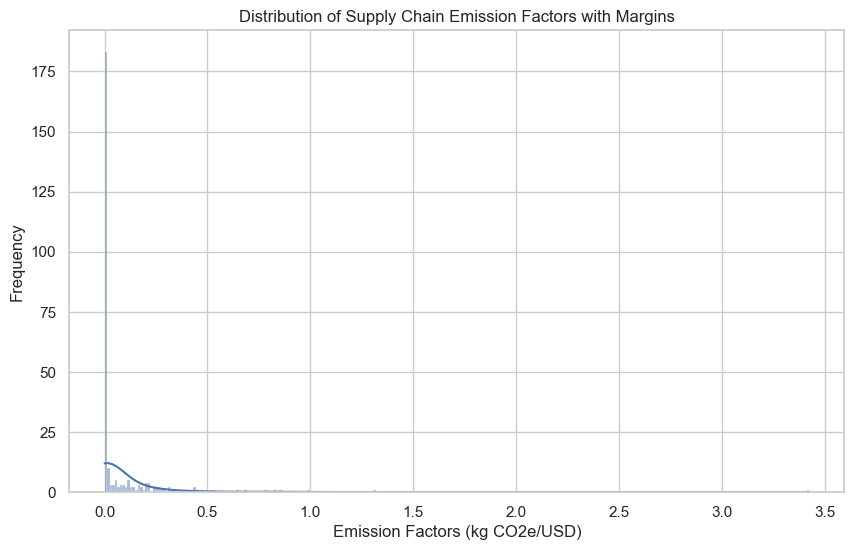

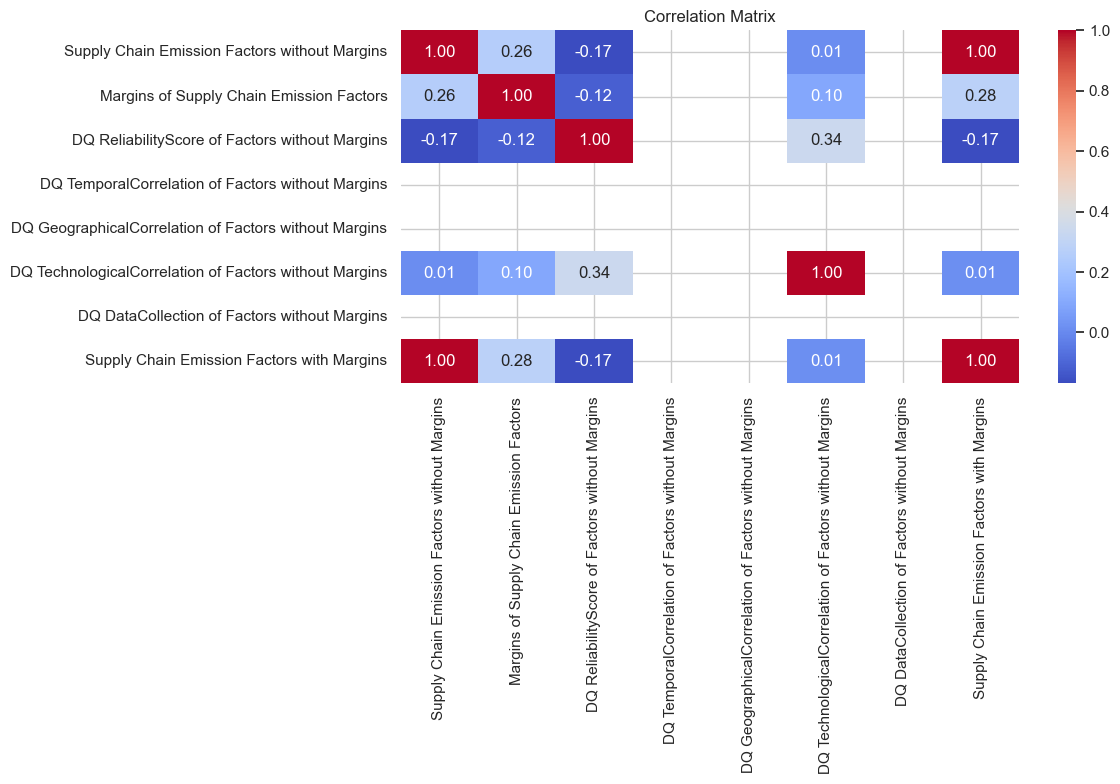

In [20]:
# ======================
# 2. EXPLORATORY DATA ANALYSIS
# ======================

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df["Supply Chain Emission Factors with Margins"], kde=True)
plt.title('Distribution of Supply Chain Emission Factors with Margins')
plt.xlabel('Emission Factors (kg CO2e/USD)')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols + ['Supply Chain Emission Factors with Margins']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [21]:
# ======================
# 3. FEATURE ENGINEERING
# ======================

# One-hot encode categorical variables
categorical_cols = ['Industry Name', 'Substance', 'Unit']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and target
X = df_encoded[numeric_cols]
y = df_encoded["Supply Chain Emission Factors with Margins"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (184, 7)
Testing set shape: (79, 7)


In [22]:
# ======================
# 4. MODEL TRAINING & EVALUATION
# ======================

# Dictionary to store model results
model_results = {}

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    model_results[model_name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Training - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Testing  - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
    
    return model, y_test_pred

# 1. Linear Regression
lr = LinearRegression()
lr_model, lr_pred = evaluate_model(lr, X_train, X_test, y_train, y_test, "Linear Regression")

# 2. Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt_model, dt_pred = evaluate_model(dt, X_train, X_test, y_train, y_test, "Decision Tree")

# 3. Random Forest
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model, rf_pred = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")


Linear Regression Performance:
Training - RMSE: 0.0002, MAE: 0.0001, R²: 1.0000
Testing  - RMSE: 0.0001, MAE: 0.0001, R²: 1.0000

Decision Tree Performance:
Training - RMSE: 0.0001, MAE: 0.0000, R²: 1.0000
Testing  - RMSE: 0.2384, MAE: 0.0325, R²: 0.6669



Random Forest Performance:
Training - RMSE: 0.0133, MAE: 0.0028, R²: 0.9934
Testing  - RMSE: 0.2581, MAE: 0.0360, R²: 0.6094


In [23]:
# ======================
# 5. RANDOM FOREST HYPERPARAMETER TUNING
# ======================

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with cross-validation
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Get best parameters and model
print("\nBest parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluate tuned Random Forest
tuned_rf_model, tuned_rf_pred = evaluate_model(best_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest")


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Tuned Random Forest Performance:
Training - RMSE: 0.0126, MAE: 0.0028, R²: 0.9941
Testing  - RMSE: 0.2574, MAE: 0.0362, R²: 0.6115


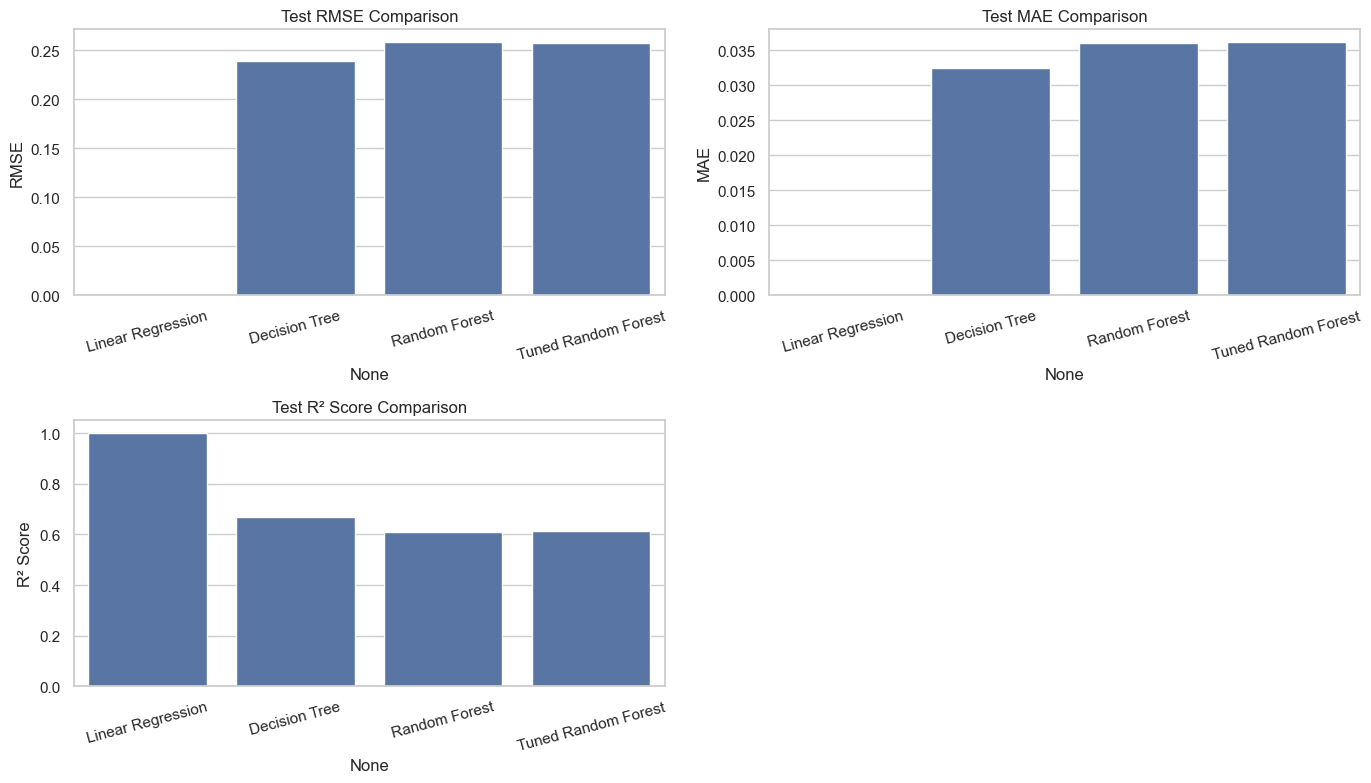

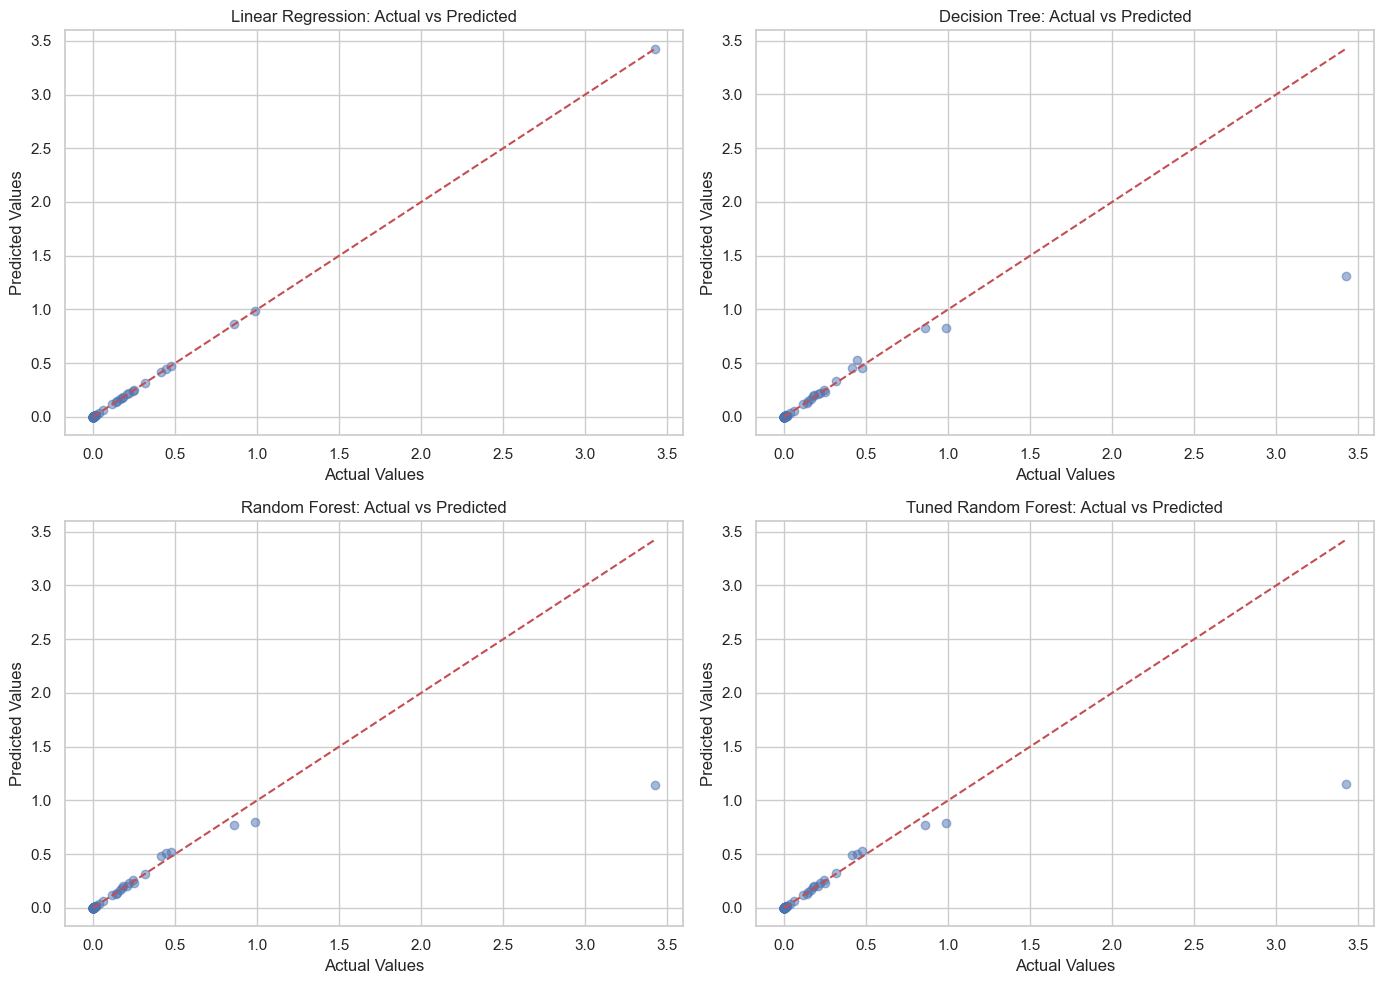

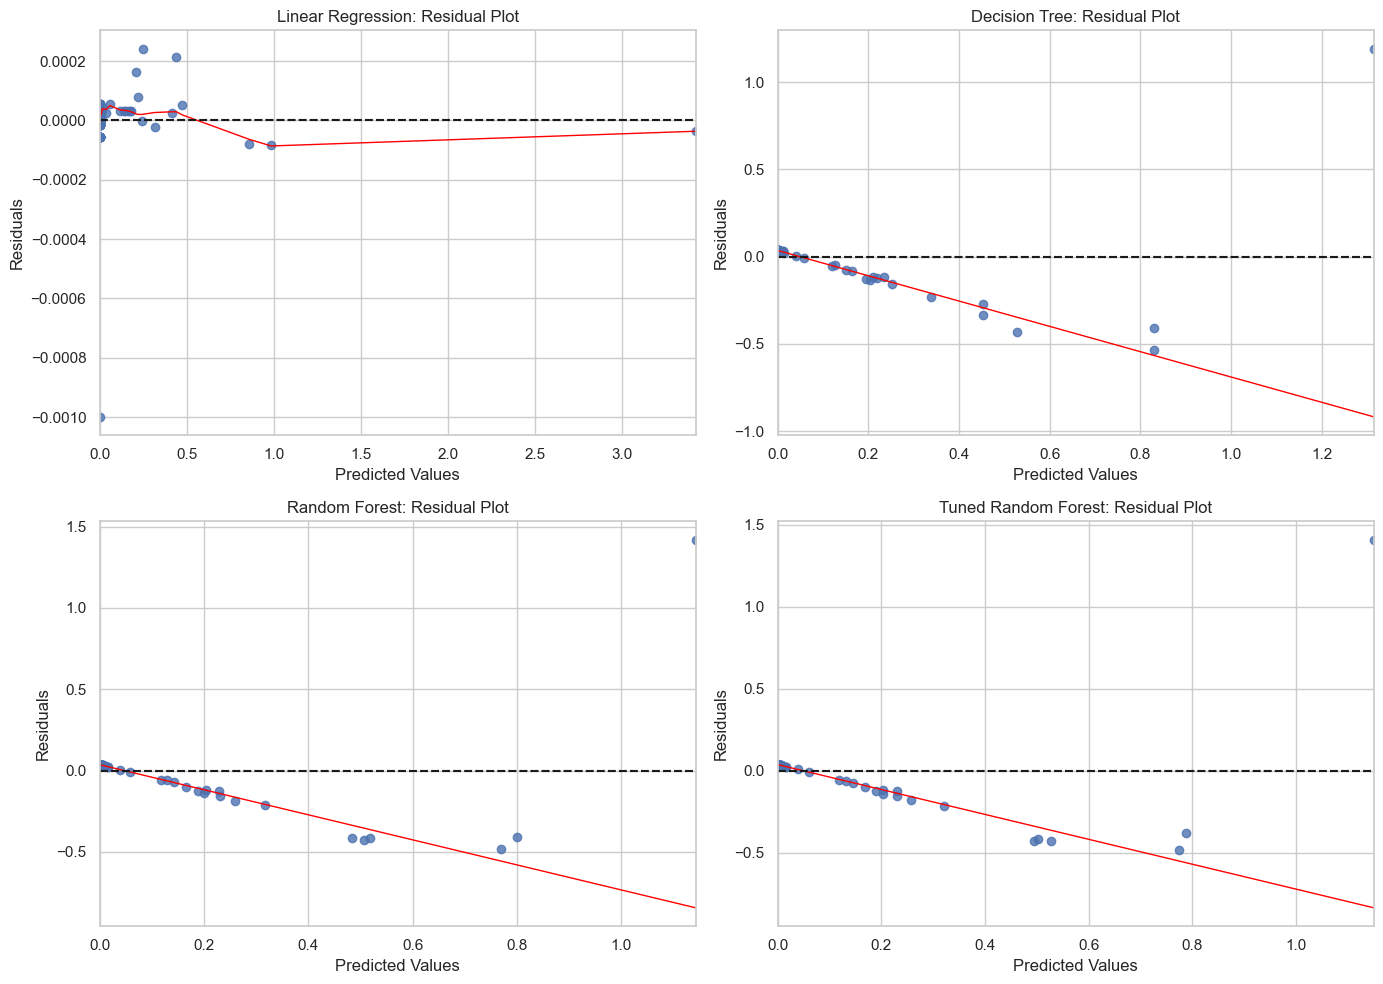

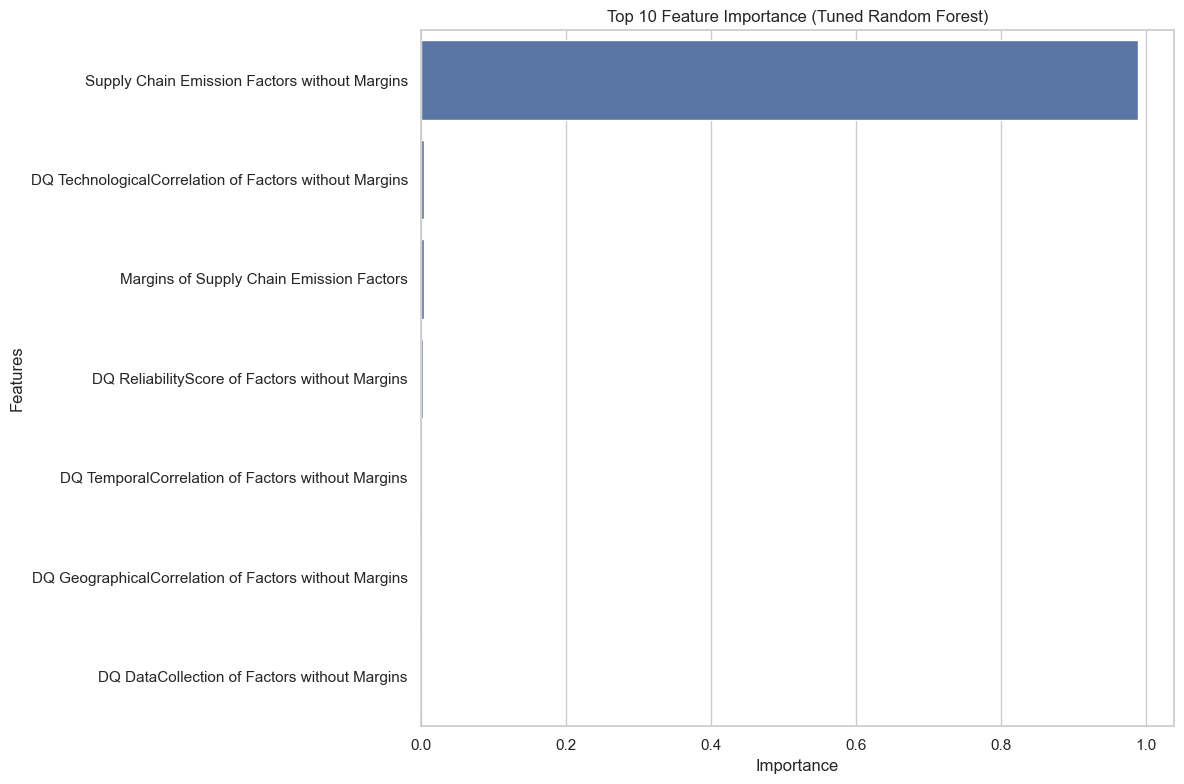

In [24]:
# ======================
# 6. VISUALIZATIONS
# ======================

# 1. Model Performance Comparison
results_df = pd.DataFrame(model_results).T

plt.figure(figsize=(14, 8))

# RMSE Comparison
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df['test_rmse'])
plt.title('Test RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=15)

# MAE Comparison
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df['test_mae'])
plt.title('Test MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=15)

# R² Comparison
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y=results_df['test_r2'])
plt.title('Test R² Score Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

# 2. Actual vs Predicted Values
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(2, 2, 1)
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted')
plt.tight_layout()

# Decision Tree
plt.subplot(2, 2, 2)
plt.scatter(y_test, dt_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree: Actual vs Predicted')
plt.tight_layout()

# Random Forest
plt.subplot(2, 2, 3)
plt.scatter(y_test, rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()

# Tuned Random Forest
plt.subplot(2, 2, 4)
plt.scatter(y_test, tuned_rf_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Tuned Random Forest: Actual vs Predicted')
plt.tight_layout()

plt.show()

# 3. Residual Plots
plt.figure(figsize=(14, 10))

# Linear Regression
plt.subplot(2, 2, 1)
residuals = y_test - lr_pred
sns.residplot(x=lr_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot')
plt.axhline(y=0, color='k', linestyle='--')

# Decision Tree
plt.subplot(2, 2, 2)
residuals = y_test - dt_pred
sns.residplot(x=dt_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Decision Tree: Residual Plot')
plt.axhline(y=0, color='k', linestyle='--')

# Random Forest
plt.subplot(2, 2, 3)
residuals = y_test - rf_pred
sns.residplot(x=rf_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Random Forest: Residual Plot')
plt.axhline(y=0, color='k', linestyle='--')

# Tuned Random Forest
plt.subplot(2, 2, 4)
residuals = y_test - tuned_rf_pred
sns.residplot(x=tuned_rf_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Tuned Random Forest: Residual Plot')
plt.axhline(y=0, color='k', linestyle='--')

plt.tight_layout()
plt.show()

# 4. Feature Importance (Tuned Random Forest)
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns)
top_features = feature_importance.nlargest(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 10 Feature Importance (Tuned Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [25]:
# ======================
# 7. SAVE THE BEST MODEL
# ======================

# Determine the best model based on test R² score
best_model_name = max(model_results, key=lambda x: model_results[x]['test_r2'])
best_model = None

if best_model_name == "Linear Regression":
    best_model = lr_model
elif best_model_name == "Decision Tree":
    best_model = dt_model
elif best_model_name == "Random Forest":
    best_model = rf_model
else:
    best_model = tuned_rf_model

print(f"\nThe best performing model is: {best_model_name} with R²: {model_results[best_model_name]['test_r2']:.4f}")

# Save the best model
model_filename = 'best_emission_prediction_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Best model saved as '{model_filename}'")

# Also save the tuned RF specifically if it's the best
if best_model_name == "Tuned Random Forest":
    joblib.dump(tuned_rf_model, 'tuned_random_forest_model.pkl')
    print("Tuned Random Forest model also saved separately")


The best performing model is: Linear Regression with R²: 1.0000
Best model saved as 'best_emission_prediction_model.pkl'


In [26]:
# ======================
# 8. FINAL MODEL SUMMARY
# ======================

print("\n===== FINAL MODEL SUMMARY =====")
print(f"Best Model: {best_model_name}")
print(f"Test RMSE: {model_results[best_model_name]['test_rmse']:.4f}")
print(f"Test MAE: {model_results[best_model_name]['test_mae']:.4f}")
print(f"Test R²: {model_results[best_model_name]['test_r2']:.4f}")
print("================================")


===== FINAL MODEL SUMMARY =====
Best Model: Linear Regression
Test RMSE: 0.0001
Test MAE: 0.0001
Test R²: 1.0000
